<a href="https://colab.research.google.com/github/satyarth42/cycle_GAN/blob/master/Cycle_Consistent_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.9 GB  | Proc size: 139.0 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
height, width = 256,256

In [0]:
batch_size = 20

In [0]:
horse_train_path = '/content/gdrive/My Drive/horse2zebra/trainA/'
zebra_train_path = '/content/gdrive/My Drive/horse2zebra/trainB/'

In [0]:
horse_train = os.listdir(horse_train_path)
zebra_train = os.listdir(zebra_train_path)

In [0]:
no_horse = len(horse_train)
no_zebra = len(zebra_train)
#no_horse,no_zebra = 200,200
print(no_horse,no_zebra)

1067 1334


In [0]:
horse_mat = np.zeros((no_horse,height,width,3))
zebra_mat = np.zeros((no_zebra,height,width,3))

In [0]:
for i in range(no_horse):
    horse_im = Image.open(horse_train_path+horse_train[i])
    horse_im = horse_im.resize((height,width))
    horse_im = horse_im.convert('RGB')
    horse_im = np.asarray(horse_im,dtype=np.float32)
    horse_mat[i,:,:,:] = horse_im
    if i%20==0:
      print(i)
horse_mat/=255.0

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060


In [0]:
for i in range(no_zebra):
    zebra_im = Image.open(zebra_train_path+zebra_train[i])
    zebra_im = zebra_im.resize((height,width))
    zebra_im = zebra_im.convert('RGB')
    zebra_im = np.asarray(zebra_im,dtype=np.float32)
    zebra_mat[i,:,:,:] = zebra_im
    if i%20==0:
      print(i)
zebra_mat/=255.0

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320


In [0]:
'''
np.save('/content/gdrive/My Drive/horse2zebra/horse_mat.npy')
np.save('/content/gdrive/My Drive/horse2zebra/zebra_mat',zebra_mat)
'''

"\nnp.save('/content/gdrive/My Drive/horse2zebra/horse_mat.npy')\nnp.save('/content/gdrive/My Drive/horse2zebra/zebra_mat',zebra_mat)\n"

In [0]:
'''
horse_mat = np.load('/content/gdrive/My Drive/horse2zebra/horse_mat.npy')
zebra_mat = np.load('/content/gdrive/My Drive/horse2zebra/zebra_mat.npy')
'''

In [0]:
input_A = tf.placeholder(dtype=tf.float32,shape = [None,height,width,3],name = 'input_A')
input_B = tf.placeholder(dtype=tf.float32,shape = [None,height,width,3],name = 'input_B')

In [0]:
def build_generator(input,name,reuse=False):
  with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE) as scope:
    
    W1 = tf.get_variable(name+'_enc_layer_1_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[5,5,3,16],minval=0.0,maxval=1.0))
    b1 = tf.get_variable(name+'_enc_layer_1_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    X = tf.add(tf.nn.conv2d(input,W1,strides=[1,2,2,1],padding='VALID'),b1)
    m1,v1 = tf.nn.moments(X,axes=[0])
    X = tf.nn.leaky_relu(tf.nn.batch_normalization(X,m1,v1,None,None,0.0002))
    
    W2 = tf.get_variable(name+'_enc_layer_2_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[3,3,16,64],minval=0.0,maxval=1.0))
    b2 = tf.get_variable(name+'_enc_layer_2_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    X = tf.add(tf.nn.conv2d(X,W2,strides=[1,1,1,1],padding='SAME'),b2)
    m2,v2 = tf.nn.moments(X,axes=[0])
    X = tf.nn.leaky_relu(tf.nn.batch_normalization(X,m2,v2,None,None,0.0002))
    
    W3 = tf.get_variable(name+'_enc_layer_3_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[3,3,64,256],minval=0.0,maxval=1.0))
    b3 = tf.get_variable(name+'_enc_layer_3_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    X = tf.add(tf.nn.conv2d(X,W3,strides=[1,2,2,1],padding='VALID'),b3)
    m3,v3 = tf.nn.moments(X,axes=[0])
    X = tf.nn.leaky_relu(tf.nn.batch_normalization(X,m3,v3,None,None,0.0002))
    
    W4 = tf.get_variable(name+'_trans_block_1.1',dtype=tf.float32,initializer=tf.random_uniform(shape=[3,3,256,256],minval=0.0,maxval=1.0))
    W5 = tf.get_variable(name+'_trans_block_1.2',dtype=tf.float32,initializer=tf.random_uniform(shape=[3,3,256,256],minval=0.0,maxval=1.0))
    out_1_1 = tf.nn.conv2d(X,W4,strides=[1,1,1,1],padding='SAME')
    out_1_2 = tf.nn.conv2d(out_1_1,W5,strides=[1,1,1,1],padding='SAME')
    
    X = tf.add(X,out_1_2)
    m4,v4 = tf.nn.moments(X,axes=[0])
    X = tf.nn.batch_normalization(X,m4,v4,None,None,0.0002)
    
    W6 = tf.get_variable(name+'_trans_block_2.1',dtype=tf.float32,initializer=tf.random_uniform(shape=[3,3,256,256],minval=0.0,maxval=1.0))
    W7 = tf.get_variable(name+'_trans_block_2.2',dtype=tf.float32,initializer=tf.random_uniform(shape=[3,3,256,256],minval=0.0,maxval=1.0))
    out_2_1 = tf.nn.conv2d(X,W6,strides=[1,1,1,1],padding='SAME')
    out_2_2 = tf.nn.conv2d(out_2_1,W7,strides=[1,1,1,1],padding='SAME')
    
    X = tf.add(X,out_2_2)
    m5,v5 = tf.nn.moments(X,axes=[0])
    X = tf.nn.batch_normalization(X,m5,v5,None,None,0.0002)
    
    W10 = tf.get_variable(name+'_trans_block_3.1',dtype=tf.float32,initializer=tf.random_uniform(shape=[3,3,256,256],minval=0.0,maxval=1.0))
    W11 = tf.get_variable(name+'_trans_block_3.2',dtype=tf.float32,initializer=tf.random_uniform(shape=[3,3,256,256],minval=0.0,maxval=1.0))
    out_3_1 = tf.nn.conv2d(X,W10,strides=[1,1,1,1],padding='SAME')
    out_3_2 = tf.nn.conv2d(out_3_1,W11,strides=[1,1,1,1],padding='SAME')
    
    X = tf.add(X,out_3_2)
    m9,v9 = tf.nn.moments(X,axes=[0])
    X = tf.nn.batch_normalization(X,m9,v9,None,None,0.0002)
    
    W7 = tf.get_variable(name+'_dec_layer_1_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[3,3,64,256],minval=0.0,maxval=1.0))
    b7 = tf.get_variable(name+'_dec_layer_1_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    X = tf.add(tf.nn.conv2d_transpose(X,W7,output_shape=[batch_size,64,64,64],strides=[1,1,1,1],padding='VALID'),b7)
    m6,v6 = tf.nn.moments(X,axes=[0])
    X = tf.nn.leaky_relu(tf.nn.batch_normalization(X,m6,v6,None,None,0.0002))
    
    
    W8 = tf.get_variable(name+'_dec_layer_2_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[3,3,16,64],minval=0.0,maxval=1.0))
    b8 = tf.get_variable(name+'_dec_layer_2_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    X = tf.add(tf.nn.conv2d_transpose(X,W8,output_shape=[batch_size,128,128,16],strides=[1,2,2,1],padding='SAME'),b8)
    m7,v7 = tf.nn.moments(X,axes=[0])
    X = tf.nn.leaky_relu(tf.nn.batch_normalization(X,m7,v7,None,None,0.0002))
    
    
    W9 = tf.get_variable(name+'_dec_layer_3_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[5,5,3,16],minval=0.0,maxval=1.0))
    b9 = tf.get_variable(name+'_dec_layer_3_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    X = tf.add(tf.nn.conv2d_transpose(X,W9,output_shape=[batch_size,256,256,3],strides=[1,2,2,1],padding='SAME'),b9)
    m8,v8 = tf.nn.moments(X,axes=[0])
    X = tf.nn.leaky_relu(tf.nn.batch_normalization(X,m8,v8,None,None,0.0002))
    X = tf.nn.sigmoid(X)
    
    return X

In [0]:
def build_discriminator(input,name,reuse=False):
  with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE) as scope:
    
    W1 = tf.get_variable(name+'_conv_layer_1_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[5,5,3,16],minval=0.0,maxval=1.0))
    b1 = tf.get_variable(name+'_conv_layer_1_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    X = tf.add(tf.nn.conv2d(input,W1,strides=[1,2,2,1],padding='VALID'),b1)
    m1,v1 = tf.nn.moments(X,axes=[0])
    X = tf.nn.leaky_relu(tf.nn.batch_normalization(X,m1,v1,None,None,0.0002))
    
    W2 = tf.get_variable(name+'_conv_layer_2_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[3,3,16,64],minval=0.0,maxval=1.0))
    b2 = tf.get_variable(name+'_conv_layer_2_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    X = tf.add(tf.nn.conv2d(X,W2,strides=[1,2,2,1],padding='VALID'),b2)
    m2,v2 = tf.nn.moments(X,axes=[0])
    X = tf.nn.leaky_relu(tf.nn.batch_normalization(X,m2,v2,None,None,0.0002))
    
    W3 = tf.get_variable(name+'_conv_layer_3_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[7,7,64,128],minval=0.0,maxval=1.0))
    b3 = tf.get_variable(name+'_conv_layer_3_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    X = tf.add(tf.nn.conv2d(X,W3,strides=[1,2,2,1],padding='VALID'),b3)
    m3,v3 = tf.nn.moments(X,axes=[0])
    X = tf.nn.leaky_relu(tf.nn.batch_normalization(X,m3,v3,None,None,0.0002))
    
    X = tf.layers.flatten(X)
    
    input_shape = int(X.shape[1])
    W4 = tf.get_variable(name+'_fc_1_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[input_shape,128],minval=0.0,maxval=1.0))
    b4 = tf.get_variable(name+'_fc_1_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    
    X = tf.add(tf.matmul(X,W4),b4)
    
    W5 = tf.get_variable(name+'_fc_2_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[128,64],minval=0.0,maxval=1.0))
    b5 = tf.get_variable(name+'_fc_2_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    
    X = tf.nn.leaky_relu(tf.add(tf.matmul(X,W5),b5))
    
    W6 = tf.get_variable(name+'_fc_3_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[64,16],minval=0.0,maxval=1.0))
    b6 = tf.get_variable(name+'_fc_3_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    
    X = tf.nn.sigmoid(tf.add(tf.matmul(X,W6),b6))
    
    W7 = tf.get_variable(name+'_fc_4_w',dtype=tf.float32,initializer=tf.random_uniform(shape=[16,1],minval=0.0,maxval=1.0))
    b7 = tf.get_variable(name+'_fc_4_b',dtype=tf.float32,initializer=tf.constant(1.0,tf.float32))
    
    out = tf.nn.sigmoid(tf.add(tf.matmul(X,W7),b7))
    
    return out

In [0]:
genA2B = build_generator(input_A,'genA2B')
genB2A = build_generator(input_B,'genB2A')

In [0]:
discA = build_discriminator(input_A,'discA')
discB = build_discriminator(input_B,'discB')

In [0]:
dec_genA2B = build_discriminator(genA2B,'discB')
dec_genB2A = build_discriminator(genB2A,'discA')

In [0]:
gen_A2B2A = build_generator(genA2B,'genB2A')
gen_B2A2B = build_generator(genB2A,'genA2B')

In [0]:
'''gen = build_generator(X,'gen')
disc = build_discriminator(X,'disc')
dec_gen = build_discriminator(gen,'disc')'''

"gen = build_generator(X,'gen')\ndisc = build_discriminator(X,'disc')\ndec_gen = build_discriminator(gen,'disc')"

In [0]:
'''gen_vars = [var for var in tf.trainable_variables() if 'gen' in var.name]
disc_vars = [var for var in tf.trainable_variables() if 'disc' in var.name]'''

"gen_vars = [var for var in tf.trainable_variables() if 'gen' in var.name]\ndisc_vars = [var for var in tf.trainable_variables() if 'disc' in var.name]"

In [0]:
'''G_loss = tf.reduce_sum(tf.square(dec_gen-0.1))
D_loss_real = tf.reduce_sum(tf.square(disc-0.1))
D_loss_fake = tf.reduce_sum(tf.squared_difference(0.9,dec_gen))'''

'G_loss = tf.reduce_sum(tf.square(dec_gen-0.1))\nD_loss_real = tf.reduce_sum(tf.square(disc-0.1))\nD_loss_fake = tf.reduce_sum(tf.squared_difference(0.9,dec_gen))'

In [0]:
'''opt = tf.train.AdamOptimizer(learning_rate=0.15)
G_opt = opt.minimize(G_loss,var_list=gen_vars)
D_real_opt = opt.minimize(D_loss_real,var_list=disc_vars)
D_fake_opt = opt.minimize(D_loss_fake,var_list=disc_vars)'''

'opt = tf.train.AdamOptimizer(learning_rate=0.15)\nG_opt = opt.minimize(G_loss,var_list=gen_vars)\nD_real_opt = opt.minimize(D_loss_real,var_list=disc_vars)\nD_fake_opt = opt.minimize(D_loss_fake,var_list=disc_vars)'

In [0]:
cyc_loss = tf.reduce_mean(tf.abs(input_A-gen_A2B2A)+tf.abs(input_B-gen_B2A2B))

In [0]:
disc_loss_A = tf.reduce_mean(tf.squared_difference(dec_genB2A,tf.ones_like(dec_genB2A)))
disc_loss_B = tf.reduce_mean(tf.squared_difference(dec_genA2B,tf.ones_like(dec_genA2B)))

In [0]:
g_loss_A = cyc_loss*10 + disc_loss_B
g_loss_B = cyc_loss*10 + disc_loss_A

In [0]:
d_loss_A = (tf.reduce_mean(tf.square(dec_genB2A)) + tf.reduce_mean(tf.squared_difference(discA,tf.ones_like(discA))))/2.0
d_loss_B = (tf.reduce_mean(tf.square(dec_genA2B)) + tf.reduce_mean(tf.squared_difference(discB,tf.ones_like(discB))))/2.0

In [0]:
optimizer = tf.train.AdamOptimizer(0.003, beta1=0.5)

In [0]:
d_A_vars = [var for var in tf.trainable_variables() if 'discA' in var.name]
g_A_vars = [var for var in tf.trainable_variables() if 'genA2B' in var.name]
d_B_vars = [var for var in tf.trainable_variables() if 'discB' in var.name]
g_B_vars = [var for var in tf.trainable_variables() if 'genB2A' in var.name]

In [0]:
d_A_trainer = optimizer.minimize(d_loss_A, var_list=d_A_vars)
d_B_trainer = optimizer.minimize(d_loss_B, var_list=d_B_vars)
g_A_trainer = optimizer.minimize(g_loss_A, var_list=g_A_vars)
g_B_trainer = optimizer.minimize(g_loss_B, var_list=g_B_vars)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
'''k = min(no_horse/batch_size,no_zebra/batch_size)
for i in range(10):
  
  D_loss = 0.0
  Gen_loss=0.0
  D_real_sum = 0.0
  D_fake_sum = 0.0
  for j in range(int(k)):
    
    zebra_mini_batch = zebra_mat[j*batch_size:(j+1)*batch_size,:,:,:]
    horse_mini_batch = horse_mat[j*batch_size:(j+1)*batch_size,:,:,:]

    _,D_real=sess.run([D_real_opt,D_loss_real],feed_dict={X:zebra_mini_batch})
    _,D_fake=sess.run([D_fake_opt,D_loss_fake],feed_dict={X:horse_mini_batch})

    D_loss += D_real+D_fake
    D_real_sum+=D_real
    D_fake_sum+=D_fake
    
    _,Gl=sess.run([G_opt,G_loss],feed_dict={X:horse_mini_batch})

    Gen_loss+=Gl
  print("iteration: "+str(i))
  print("D_loss: "+str(D_loss)+" G_loss: "+str(Gen_loss))
  '''

'k = min(no_horse/batch_size,no_zebra/batch_size)\nfor i in range(10):\n  \n  D_loss = 0.0\n  Gen_loss=0.0\n  D_real_sum = 0.0\n  D_fake_sum = 0.0\n  for j in range(int(k)):\n    \n    zebra_mini_batch = zebra_mat[j*batch_size:(j+1)*batch_size,:,:,:]\n    horse_mini_batch = horse_mat[j*batch_size:(j+1)*batch_size,:,:,:]\n\n    _,D_real=sess.run([D_real_opt,D_loss_real],feed_dict={X:zebra_mini_batch})\n    _,D_fake=sess.run([D_fake_opt,D_loss_fake],feed_dict={X:horse_mini_batch})\n\n    D_loss += D_real+D_fake\n    D_real_sum+=D_real\n    D_fake_sum+=D_fake\n    \n    _,Gl=sess.run([G_opt,G_loss],feed_dict={X:horse_mini_batch})\n\n    Gen_loss+=Gl\n  print("iteration: "+str(i))\n  print("D_loss: "+str(D_loss)+" G_loss: "+str(Gen_loss))\n  '

In [0]:
batch_n = min(no_horse/batch_size,no_zebra/batch_size)
for epoch in range(1,5):
  print("Epoch: "+str(epoch))
  
  gen_A2B_loss,gen_B2A_loss,discA_loss,discB_loss = 0.0,0.0,0.0,0.0
  
  for ptr in range(int(batch_n)):
    
    A_batch = horse_mat[ptr*batch_size:(ptr+1)*batch_size,:,:,:]
    B_batch = zebra_mat[ptr*batch_size:(ptr+1)*batch_size,:,:,:]
    
    _,gA2B_loss,_,dB_loss,_,gB2A_loss,_,dA_loss = sess.run([g_A_trainer,g_loss_A,d_B_trainer,d_loss_B,g_B_trainer,g_loss_B,d_A_trainer,d_loss_A],feed_dict={input_A:A_batch,input_B:B_batch})
    
    gen_A2B_loss+=gA2B_loss
    gen_B2A_loss+=gB2A_loss
    discA_loss+=dA_loss
    discB_loss+=dB_loss
    
  print('genA2B:'+str(gen_A2B_loss/batch_n),'genB2A:'+str(gen_B2A_loss/batch_n),'discA:'+str(discA_loss/batch_n),'discB:'+str(discB_loss/batch_n))

Epoch: 1
genA2B:3.8509188306141704 genB2A:3.846032925599517 discA:0.36495795234297634 discB:0.3648518303788032
Epoch: 2
genA2B:3.9526059857683977 genB2A:3.9453796504699077 discA:0.26509967437947923 discB:0.2639105874126831
Epoch: 3
genA2B:3.96317351501236 genB2A:3.957007371496685 discA:0.257780266735413 discB:0.257590033232663
Epoch: 4
genA2B:3.9735621163637256 genB2A:3.9682109621829147 discA:0.2522376135005611 discB:0.2528541984129086


In [0]:
pic = sess.run(genA2B,feed_dict={input_A:horse_mat[0:batch_size,:,:,:]})
pic2 = sess.run(gen_A2B2A,feed_dict={input_A:horse_mat[0:batch_size,:,:,:]})

In [0]:
sess.close()

In [0]:
tf.reset_default_graph()

In [0]:
horse_mat.shape

(1067, 256, 256, 3)

In [0]:
zebra_mat.shape

(1334, 256, 256, 3)

In [0]:
pic[0].shape

(256, 256, 3)

In [0]:
index_no = 3

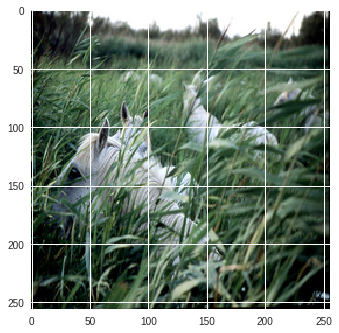

In [0]:
plt.imshow(horse_mat[index_no])
plt.show()

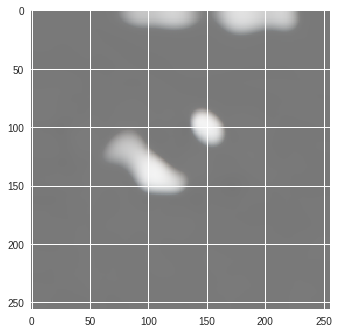

In [0]:
plt.imshow(pic[index_no])
plt.show()

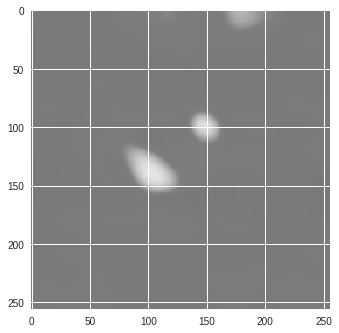

In [0]:
plt.imshow(pic2[index_no])
plt.show()